# Event Rate

In [59]:
import numpy as np
import math
import matplotlib.pyplot as plt
import sympy as sp
import time
import concurrent.futures
from multiprocessing import Pool
from scipy import integrate
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.stats import skewnorm
from matplotlib import rcParams
from astropy import units as u
from astropy.constants import G, c, M_sun, R_sun, L_sun, au, pc
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import FlatLambdaCDM
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.noise import noise_from_psd

from tabulate import tabulate
config = {
            "font.family": 'serif',
            "font.size": 12,
            "mathtext.fontset": 'stix',
            "font.serif": ['Times New Roman'],
            'axes.unicode_minus': False
         }
rcParams.update(config)

#### The simulation of number of COs

In [4]:
# Data
# model III, data from fig.4    
x3 = [0, 0.6, 1.0, 1.3, 1.5, 2.0, 2.3, 2.85, 3.0, 3.3, 3.5, 4.0, 5.0]
y3 = [80, 250, 380, 500, 575, 680, 750, 800, 750, 500, 250, 75, 0]

x4 = [0.0, 0.55, 1.0, 1.1, 2.0, 2.85, 3.0, 3.35, 3.5, 4.0, 5.0]
y4 = [50, 125, 200, 250, 375, 440, 375, 250, 125, 20, 0]

x5 = [0.0, 0.1, 0.5, 0.75, 1.0, 1.4, 1.5, 1.65, 2.0, 2.65, 3.0, 3.1, 3.2, 3.3, 3.4, 3.45, 3.55, 3.65, 4.0, 5.0]
y5 = [190, 250, 500, 750, 950, 1250, 1350, 1500, 1685, 2000, 1875, 1750, 1500, 1250, 1000, 750, 500, 250, 60, 0]

* **Skewed Normal Distribution**

  

In [10]:
def skewnorm_gaussian(x, a, loc, scale, amp):
    return amp * skewnorm.pdf(x, a, loc, scale)

def fit_sn(x, y):
    psn, _ = curve_fit(skewnorm_gaussian, x, y, p0=[1, 2, 1, 800])
    x_sn = np.linspace(0, 5, 100)
    y_sn = skewnorm_gaussian(x_sn, *psn)
    return x_sn, y_sn, psn

x3_sn, y3_sn, psn3 = fit_sn(x3, y3)
x4_sn, y4_sn, _ = fit_sn(x4, y4)
x5_sn, y5_sn, psn5 = fit_sn(x5, y5)

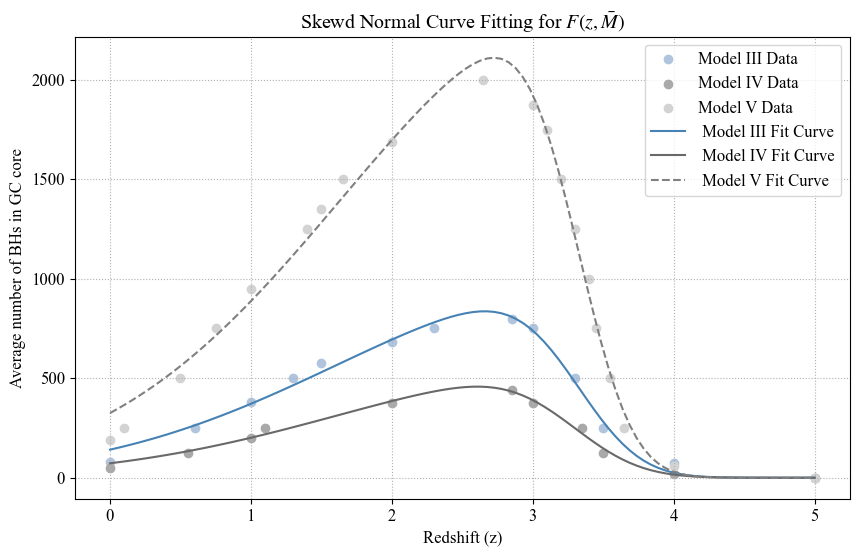

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(x3, y3, label='Model III Data', color='lightsteelblue')
plt.scatter(x4, y4, label='Model IV Data', color='darkgrey')
plt.scatter(x5, y5, label='Model V Data', color='lightgrey')
plt.plot(x3_sn, y3_sn, label=' Model III Fit Curve', color='steelblue')
plt.plot(x4_sn, y4_sn, label=' Model IV Fit Curve', color='dimgrey')
plt.plot(x5_sn, y5_sn, label=' Model V Fit Curve', color='grey', linestyle = '--')
plt.legend()
plt.grid(linestyle = ':')
plt.xlabel(r'Redshift (z)')
plt.ylabel('Average number of BHs in GC core')
plt.title(r'Skewd Normal Curve Fitting for $F(z, \bar{M})$')
plt.show()

## Part I: Estimation on picking-values

In [21]:
# constant lsit
m1 = 10*M_sun                # the mass of the CO
m2 = 10*M_sun                # the mass of the CO
M = m1+m2                    # the total mass
R_cluster = 10*pc            # the radius of the cluster
R_co = 0.5*pc                # the radius of the dense core of the cluster
n_gc = 200                   # the number of GC per MWEG
n_z = 0.0116*(u.Mpc**(-3))   # the number density of MWEG at different redshift
n_z = n_z.to(u.m**-3)
omega_L = 0.685              # standard cosmological parameters
omega_m = 0.315
H0 = cosmo.H0.to(u.s**-1)
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.315, Tcmb0=2.7255)


In [23]:
z = np.linspace(0.0002, 5, 1000)

# vi, according to the Virial Theorem
def initial_velocity(n_star, m, R_cluster):
    # n_star : the number of the stars in the cluster
    # m : the average mass of a star
    # R_cluster : the radius of the cluster
    return np.sqrt(G*n_star*m/3/R_cluster)

# 1/E(z), according to the flat universe
def inverse_Hubble_parameter(zz):
    return 1./np.sqrt(omega_L+omega_m*(1+zz)**3)

# 2 different ways to calculate comoving distance
# comoving distance calculated according to the definition
def comoving_r(zz):
    r, _ = quad(inverse_Hubble_parameter, 0.0002, 5.0)
    return (c/H0*r).to(u.Mpc)

# directly using the astropy
def comoving_distance(zz):
    r = cosmo.comoving_distance(zz)
    return r.to(u.m)

# time dilation
def time_dilation(zz):
    zz = zz * u.dimensionless_unscaled
    t = 1. / (1 + zz)
    t = t*u.s
    return t

# N(z), the number of galaxies at different redshift
def number_galaxy(zz):
    return 4*np.pi/H0*comoving_distance(zz)**2*c*n_z*inverse_Hubble_parameter(zz)

# n_co(z), the number of the compact objects in one GC core
# Here we use the distribution f(z,M)
def number_co(zz, psn):
    return skewnorm_gaussian(zz, *psn)

def impact_parameter(m, vi, ri, theta_i):
    rs = 2*G*m/c**2
    # using the approximation, e \sim 1
    bmin = 2*np.sqrt(G*2*m*rs)/vi # here the mass should be the total mass
    bmin = bmin.to(u.m)
    bmax = ri*theta_i
    bmax = bmax.to(u.m)
    return bmax**2-bmin**2

def prob_cluster(vi, zz, psn, m, ri, theta_i):
    const1 = 3*vi*impact_parameter(m, vi, ri, theta_i)/4/R_co**3
    const2 = np.log(R_co/R_co)
    return const1*number_co(zz, psn)**2*(const2+(1/3)*np.log(number_co(zz, psn)))

def number_event(vi, zz, psn, m, ri, theta_i):
    return 3.1536*10**7*time_dilation(zz)*prob_cluster(vi, zz, psn, m, ri, theta_i)*n_gc*number_galaxy(zz)

def prob_total(vi, zz, psn, m, ri, theta_i):
    ptotal = lambda zz: number_event(vi, zz, psn, m, ri, theta_i)
    event_rate, _ = quad(ptotal, 0.0002, 5.0)
    return event_rate

In [25]:
vi_norm = initial_velocity(8*10**5, 1*M_sun, 10*pc)
vi_V = initial_velocity(1.6*10**6, 1*M_sun, 10*pc)

cr1 = comoving_r(z)
cr2 = comoving_distance(z)
cr1,cr2[-1]**2, c/H0, vi_norm, vi_V

(<Quantity 7945.11726789 Mpc>,
 <Quantity 6.00796629e+52 m2>,
 <Quantity 1.37249683e+26 m>,
 <Quantity 10709.39434333 m / s>,
 <Quantity 15145.37072514 m / s>)

In [67]:
"""
For Model III,

initial velocity is the normal one vi_nrom = 10.69 km/s
psn3 is the parameter for skew norm distribution
m1, ri, theta_i are the parameters for calculating the b^2

"""
event3_CE2 = number_event(vi_norm, z, psn3, m1, 0.5*pc, 0.1*au/0.5/pc)
event3_ETD = number_event(vi_norm, z, psn3, m1, 0.5*pc, 5.5*10**-7)
event3_Aplus = number_event(vi_norm, z, psn3, m1, 0.5*pc, 3.0*10**-7)

event5_Aplus = number_event(vi_V, z, psn5, m1, 0.5*pc, 3.0*10**-7)
event5_ETD = number_event(vi_V, z, psn5, m1, 0.5*pc, 5.5*10**-7)

ptotal3_CE2 = prob_total(vi_norm, z, psn3, m1, 0.5*pc, 0.1*au/0.5/pc)
ptotal3_ETD = prob_total(vi_norm, z, psn3, m1, 0.5*pc, 5.5*10**-7)
ptotal3_Aplus = prob_total(vi_norm, z, psn3, m1, 0.5*pc, 3.0*10**-7)

ptotal5_ETD = prob_total(vi_norm, z, psn5, m1, 0.5*pc, 5.5*10**-7)
ptotal5_Aplus = prob_total(vi_norm, z, psn5, m1, 0.5*pc, 3.0*10**-7)

ptotal3_CE2, ptotal3_ETD, ptotal3_Aplus, ptotal5_ETD, ptotal5_Aplus


headers = [" ", "Model III", "", "Model V", ""]
rows = [
    ["ETD", ptotal3_ETD, 0.44, ptotal5_ETD, 2.23],
    ["A+", ptotal3_Aplus, 0.14, ptotal5_Aplus, 0.70],
    ["CE2", ptotal3_CE2, 1.38, "", ""]]
print(tabulate(rows, headers, tablefmt="rst"))

====  ===========  ====  ==================  ====
..      Model III        Model V
====  ===========  ====  ==================  ====
ETD       4.15788  0.44  29.073935945027024  2.23
A+        1.12178  0.14  7.844063442650588   0.7
CE2      13.2687   1.38
====  ===========  ====  ==================  ====


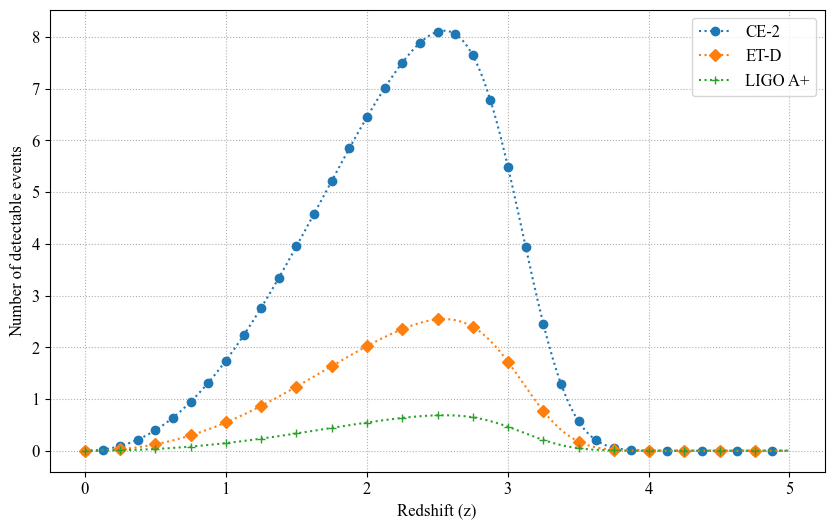

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(z, event3_CE2, linestyle=':', marker='o', markevery=25, label='CE-2')
plt.plot(z, event3_ETD, linestyle=':', marker='D', markevery=50, label='ET-D')
plt.plot(z, event3_Aplus, linestyle=':', marker='+', markevery=50, label='LIGO A+')
plt.grid(linestyle = ':')
plt.xlabel(r'Redshift (z)')
plt.ylabel('Number of detectable events')
plt.legend()
plt.show()


In [31]:
num_co = lambda zz: number_co(zz, psn3)
nco, _ = quad(num_co, 0.0002, 5.0)
nco
nco**2*(np.log(R_cluster/R_co)+(1/3)*np.log(nco))

<Quantity 19703180.23066381>

In [33]:
num_gal = lambda zz: number_galaxy(zz)
gal, _ = quad(num_gal, 0.0002, 5.0)
gal

24367623217.425415

In [422]:
bmax**2-bmin**2

<Quantity 2.22428313e+20 m2>

## Part II: 

Haven't finished...

In [ ]:

class gcluster:
# ----------------------------
# n_star : the number of the stars in the cluster
# m : the average mass of a star in the cluster
# R_cluster : the radius of the cluster
# R_core : the radius of the core of the cluster
# ....
# maybe the number of compact objects will be included here
# ----------------------------    
    def __init__(self, n_star, m, R_cluster, R_core):
        self.n = n_star
        self.m = m
        self.Rc = R_cluster
        self.Rco = R_core
    def initial_velocity:
        return np.sqrt(G*self.n*self.m/3/self.Rc)

class hyperbolic_orbit:
    def __init__(self, m1, m2, cluster, ri, theta_i):
        # mass
        self.m1 = m1
        self.m2 = m2
        self.M = m1+m2
        self.mu = m1*m2/(m1+m2)
        
        # initial conditions
        self.vi = cluster.initial_velocity()
        self.ri = ri
        self.theta_i = theta_i
        
        # system set, coordinate
        self.L = self.ri*self.vi*self.theta_i
        self.phi = np.linspace(0, 2*np.pi, 1000)

        # hyperbola parameters
        self.b = self.ri*self.theta_i 
        self.a = G*self.M/self.vi**2
        self.alpha = 1-2*self.a/self.ri
        self.beta = np.cos(self.theta_i)/(1-self.b**2/self.a/self.ri)
        self.p = self.L**2/(G*self.M)
        self.e = self.eccentricity()
        self.phi0 = self.periastron_angle()
        self.rp = self.periastron_distance()

    def eccentricity(self):
        return np.sqrt(1+self.alpha*self.b**2/self.a**2)

    def periastron_angle(self):
        tan_phi0 = -self.beta*self.b/self.a
        return np.arctan(tan_phi0)

    def periastron_distance(self):
        rp = self.L**2/G/self.M/(1+self.e)
        return rp

    def orbit(self):
        r_phi = self.p/(1+self.e*np.cos(self.phi-self.phi0))
        return r_phi
        

class GW_hyperbolic:


class event_rate:

In [ ]:
if __name__ == "__main__":
    n_star = 1000
    m = 1*M_sun
    m1 = 10*M_sun
    m2 = 10*M_sun
    R_cluster = 10*pc
    R_co = 0.5*pc
    ri = 0.5*pc
    theta_i = 1.5*10**-7

    cluster = gcluster(n_star, m, R_cluster, R_co)
    orbit = hyperbolic_orbit(m1, m2, cluster, ri, theta_i)

In [35]:
hp, _ = get_td_waveform(approximant="SEOBNRv4_opt", mass1=10, mass2=10, delta_t=1.0/4096, f_lower=20)
psd = aLIGOZeroDetHighPower(len(hp) // 2 + 1, 1.0 / hp.delta_t, 20)


In [ ]:
# noise = noise_from_psd(len(hp), hp.delta_t, psd)
data = noise + hp
snr = matched_filter(hp, data, psd=psd, low_frequency_cutoff=20)